In [1]:
import torch
import pickle
import numpy as np
from os.path import exists
from keras.datasets import cifar10
from robustbench.utils import load_model
from manifold_angles import ManifoldAngles
from resnet import ResNet34
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt # try plotly express

c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
def get_model_predictions(model, data):
  predictions = []
  BATCH_SIZE = 50 # 50 seems to work, maybe try to increase

  for i in range(0, data.shape[0], BATCH_SIZE):
    print(f'BATCH: {i} to {i + BATCH_SIZE}')
    input_slice = data[i : i + BATCH_SIZE].type(torch.FloatTensor).cuda()
    output_slice = model(input_slice)
    del input_slice

    predictions.extend(output_slice.cpu().detach().numpy())
    del output_slice

  return np.array(predictions)

In [5]:
models = ['./ckpt_100ep 1.pth']
'''
[
  'Wang2023Better_WRN-70-16',
  'Wang2023Better_WRN-28-10',
  'Rebuffi2021Fixing_70_16_cutmix_extra',
  'Gowal2020Uncovering_extra',
  'Rebuffi2021Fixing_70_16_cutmix_ddpm',
  'Rebuffi2021Fixing_28_10_cutmix_ddpm',
  'Sehwag2021Proxy',
  'Rade2021Helper_R18_ddpm',
  'Rebuffi2021Fixing_R18_cutmix_ddpm',
  'Gowal2020Uncovering',
  # new
  'Wu2020Adversarial',
  'Engstrom2019Robustness',
  'Rice2020Overfitting',
  'Rony2019Decoupling',
  'Ding2020MMA'
]
'''

"\n[\n  'Wang2023Better_WRN-70-16',\n  'Wang2023Better_WRN-28-10',\n  'Rebuffi2021Fixing_70_16_cutmix_extra',\n  'Gowal2020Uncovering_extra',\n  'Rebuffi2021Fixing_70_16_cutmix_ddpm',\n  'Rebuffi2021Fixing_28_10_cutmix_ddpm',\n  'Sehwag2021Proxy',\n  'Rade2021Helper_R18_ddpm',\n  'Rebuffi2021Fixing_R18_cutmix_ddpm',\n  'Gowal2020Uncovering',\n  # new\n  'Wu2020Adversarial',\n  'Engstrom2019Robustness',\n  'Rice2020Overfitting',\n  'Rony2019Decoupling',\n  'Ding2020MMA'\n]\n"

Checking existing curvature sets for Wang2023Better_WRN-70-16
Checking existing curvature sets for Wang2023Better_WRN-28-10
Checking existing curvature sets for Rebuffi2021Fixing_70_16_cutmix_extra
Checking existing curvature sets for Gowal2020Uncovering_extra
Checking existing curvature sets for Rebuffi2021Fixing_70_16_cutmix_ddpm
Checking existing curvature sets for Rebuffi2021Fixing_28_10_cutmix_ddpm
Checking existing curvature sets for Sehwag2021Proxy
Checking existing curvature sets for Rade2021Helper_R18_ddpm
Checking existing curvature sets for Rebuffi2021Fixing_R18_cutmix_ddpm
Checking existing curvature sets for Gowal2020Uncovering
Checking existing curvature sets for Wu2020Adversarial
Checking existing curvature sets for Engstrom2019Robustness
Checking existing curvature sets for Rice2020Overfitting
Checking existing curvature sets for Rony2019Decoupling
Checking existing curvature sets for Ding2020MMA


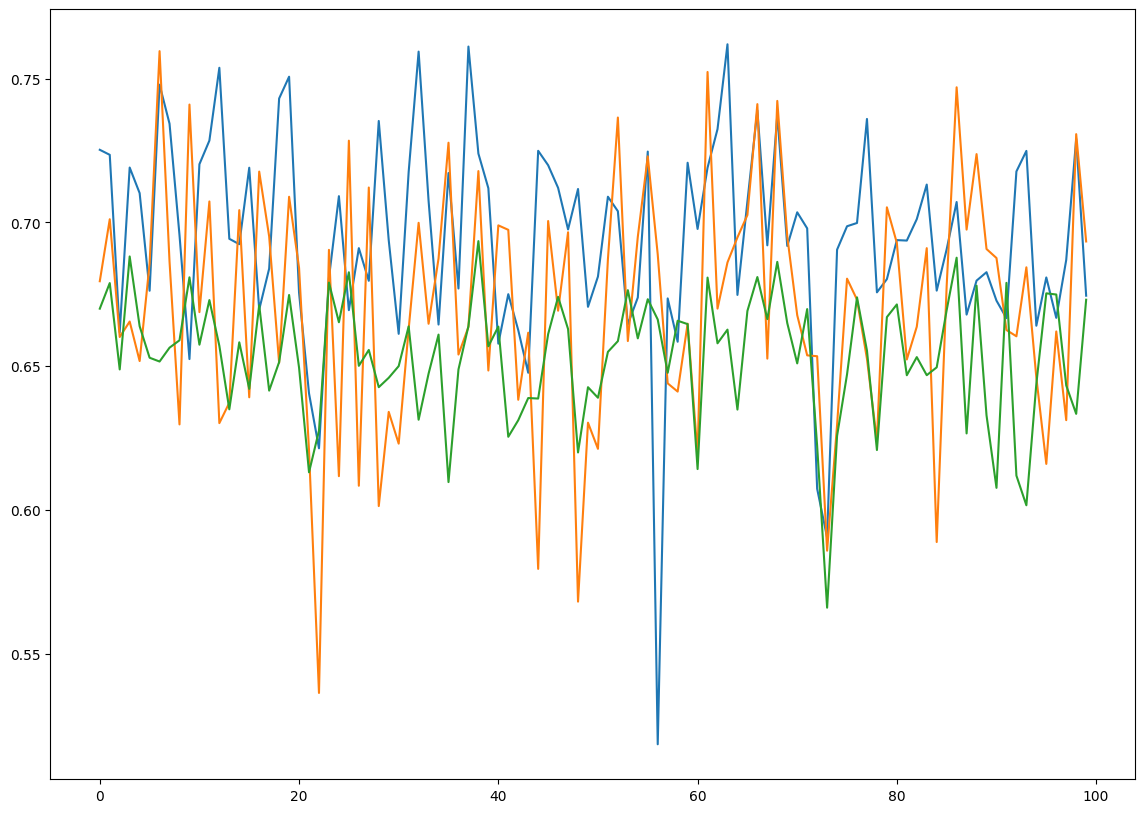

In [33]:
'''
curvatures = []

for model_name in models:
  print(f'Checking existing curvature sets for {model_name}')
  curvatures_path_name = f'./cached/output_curv/cifar_output_curv_{model_name}'
  if not exists(curvatures_path_name):
    print(f'  Curvatures for {model_name} not found.')
  else:
    with open(curvatures_path_name, 'rb') as file:
      curvatures_i = pickle.load(file).squeeze()
      curvatures.append(curvatures_i[2][:100])
      file.close()

with open('./cached/output_curv/cifar_output_curv_AVG_15', 'rb') as file:
  curvatures_i = pickle.load(file).squeeze()
  curvatures.append(curvatures_i[2][:100])
  file.close()

plt.figure(figsize=(14, 10))
plt.plot(range(100), np.array(curvatures[13:]).T)
'''

In [6]:
for model_name in models:
  print(f'Checking existing predictions for {model_name}')
  predictions_path_name = f'./cached/predictions/cifar_predictions_{model_name.split("/")[-1]}'
  if exists(predictions_path_name):
    print(f'  Predictions for {model_name} already exists.')
  else:
    print(f'  Predictions for {model_name} not found.')
    # load model into gpu
    print('  Loading model...')
    ####### TEST ############
    # Model
    net = ResNet34()
    net = net.to('cuda')
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
    checkpoint = torch.load(model_name)
    net.load_state_dict(checkpoint['net'])
    model = net#load_model(model_name=model_name, dataset='cifar10', threat_model='L2').cuda()
    ####### TEST ############
    print('  Loading dataset...')
    (cifar_X_train, _), (_, _) = cifar10.load_data()
    del _ # don't save stuff we're not using
    cifar_X_train = cifar_X_train / 255
    model_inputs = torch.from_numpy(np.reshape(cifar_X_train, (cifar_X_train.shape[0], 3, 32, 32)))

    print('  Generating predictions...')
    predictions = get_model_predictions(model, model_inputs)
    print('len predictions:', len(predictions))

    print(f'  Saving predictions to {predictions_path_name}')
    with open(predictions_path_name, 'wb') as file:
      pickle.dump(predictions, file)
      file.close()

    # clean up
    del model, cifar_X_train, model_inputs, predictions, file

  print(f'Checking existing curvature sets for {model_name}')
  curvatures_path_name = f'./cached/output_curv/cifar_output_curv_{model_name.split("/")[-1]}'
  if exists(curvatures_path_name):
    print(f'  Curvatures for {model_name} already exists.')
  else:
    print(f'  Curvatures for {model_name} not found.')
    with open(predictions_path_name, 'rb') as file:
      predictions = np.array(pickle.load(file))
      file.close()

    print('  Loading dataset...')
    (_, cifar_train_y), (_, _) = cifar10.load_data()
    del _, file # don't save stuff we're not using
    
    curvatures = []
    print('   Generating curvatures:')
    for y_class in range(10):
      print(f'     Generating curvature for class {y_class}...')
      # try inputs here
      _, manifold_neighbour_angle_sum = ManifoldAngles([predictions[cifar_train_y[:, 0] == y_class]], classsize=1, neighboursize1=10, dim_reduc_size=5) # check if the reduction quality is low, if so raise numneighbors/reduction size
      curvatures.append(np.array(manifold_neighbour_angle_sum))
      del _, manifold_neighbour_angle_sum

    print(f'  Saving curvatures to {curvatures_path_name}')
    with open(curvatures_path_name, 'wb') as file:
      pickle.dump(np.array(curvatures), file)
      file.close()

    # clean up
    del predictions, cifar_train_y, curvatures, file

Checking existing predictions for ./ckpt_100ep 1.pth
  Predictions for ./ckpt_100ep 1.pth not found.
  Loading model...
  Loading dataset...
  Generating predictions...
BATCH: 0 to 50
BATCH: 50 to 100
BATCH: 100 to 150
BATCH: 150 to 200
BATCH: 200 to 250
BATCH: 250 to 300
BATCH: 300 to 350
BATCH: 350 to 400
BATCH: 400 to 450
BATCH: 450 to 500
BATCH: 500 to 550
BATCH: 550 to 600
BATCH: 600 to 650
BATCH: 650 to 700
BATCH: 700 to 750
BATCH: 750 to 800
BATCH: 800 to 850
BATCH: 850 to 900
BATCH: 900 to 950
BATCH: 950 to 1000
BATCH: 1000 to 1050
BATCH: 1050 to 1100
BATCH: 1100 to 1150
BATCH: 1150 to 1200
BATCH: 1200 to 1250
BATCH: 1250 to 1300
BATCH: 1300 to 1350
BATCH: 1350 to 1400
BATCH: 1400 to 1450
BATCH: 1450 to 1500
BATCH: 1500 to 1550
BATCH: 1550 to 1600
BATCH: 1600 to 1650
BATCH: 1650 to 1700
BATCH: 1700 to 1750
BATCH: 1750 to 1800
BATCH: 1800 to 1850
BATCH: 1850 to 1900
BATCH: 1900 to 1950
BATCH: 1950 to 2000
BATCH: 2000 to 2050
BATCH: 2050 to 2100
BATCH: 2100 to 2150
BATCH: 2150 to

In [49]:
test_set_cube = [[1., 0.], [2., 2.64], [3., 4.625], [4., 6.05], [5., 7], [6., 7.58], [7., 7.875], [8., 7.98], [9., 8], [10., 8.01], [11., 8.125], [12., 8.42], [13., 9], [14., 9.95], [15, 11.375], [16, 13.36], [17, 16], [18, 19.39], [19, 23.625], [20, 28.797]]
test_set_square = [[1., 4.], [2., 15.], [3., 24.], [4., 31.], [5., 36.], [6., 39], [7., 40], [8., 39.], [9., 36.], [10., 31.], [11., 24.], [12., 15.], [13., 4.]]

test_set = test_set_cube
test_set = torch.Tensor(test_set)
test_set.to('cpu')
res = ManifoldAngles([test_set], classsize=1, neighboursize1=3, dim_reduc_size=5)
[x[0] for x in res[1]]

start: 
--layer time:  1.0037269592285156
--angle time:  0.10422086715698242
Average reduction quality:  1
endtime:  1.111799955368042


[<tf.Tensor: shape=(), dtype=float32, numpy=0.16294543>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.16294543>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.24431337>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.28640497>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.28500363>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.2239839>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.12136197>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.040844854>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.040844854>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.037686992>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.120668866>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.22430913>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.28401113>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.28579813>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.24431337>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.18751691>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.13634321>,
 <tf.Tensor: shape=(), dtype

Text(0.5, 0, 'Feat 2')

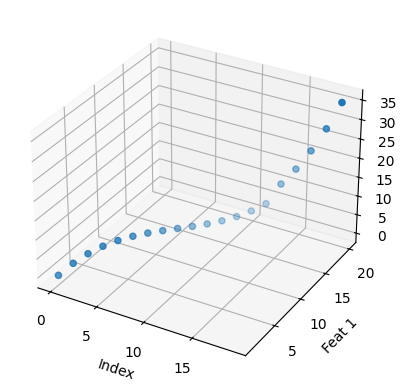

In [48]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(range(test_set.shape[0]), test_set[:, 0], test_set[:, 1])
ax.set_xlabel('Index')
ax.set_ylabel('Feat 1')
ax.set_zlabel('Feat 2')

In [12]:
import tensorflow as tf

In [17]:
tf.math.subtract(test_set, [1., 50.])

<tf.Tensor: shape=(13, 2), dtype=float32, numpy=
array([[ 0.,  0.],
       [ 1.,  0.],
       [ 3.,  0.],
       [ 9.,  0.],
       [19.,  0.],
       [23.,  0.],
       [25.,  0.],
       [23.,  0.],
       [19.,  0.],
       [ 9.,  0.],
       [ 3.,  0.],
       [ 1.,  0.],
       [ 0.,  0.]], dtype=float32)>

In [14]:
layer_features = test_set
for i, x_i in enumerate(layer_features):
    print(tf.math.subtract(layer_features,x_i))

tf.Tensor(
[[ 0.  0.]
 [ 1.  0.]
 [ 3.  0.]
 [ 9.  0.]
 [19.  0.]
 [23.  0.]
 [25.  0.]
 [23.  0.]
 [19.  0.]
 [ 9.  0.]
 [ 3.  0.]
 [ 1.  0.]
 [ 0.  0.]], shape=(13, 2), dtype=float32)
tf.Tensor(
[[-1.  0.]
 [ 0.  0.]
 [ 2.  0.]
 [ 8.  0.]
 [18.  0.]
 [22.  0.]
 [24.  0.]
 [22.  0.]
 [18.  0.]
 [ 8.  0.]
 [ 2.  0.]
 [ 0.  0.]
 [-1.  0.]], shape=(13, 2), dtype=float32)
tf.Tensor(
[[-3.  0.]
 [-2.  0.]
 [ 0.  0.]
 [ 6.  0.]
 [16.  0.]
 [20.  0.]
 [22.  0.]
 [20.  0.]
 [16.  0.]
 [ 6.  0.]
 [ 0.  0.]
 [-2.  0.]
 [-3.  0.]], shape=(13, 2), dtype=float32)
tf.Tensor(
[[-9.  0.]
 [-8.  0.]
 [-6.  0.]
 [ 0.  0.]
 [10.  0.]
 [14.  0.]
 [16.  0.]
 [14.  0.]
 [10.  0.]
 [ 0.  0.]
 [-6.  0.]
 [-8.  0.]
 [-9.  0.]], shape=(13, 2), dtype=float32)
tf.Tensor(
[[-19.   0.]
 [-18.   0.]
 [-16.   0.]
 [-10.   0.]
 [  0.   0.]
 [  4.   0.]
 [  6.   0.]
 [  4.   0.]
 [  0.   0.]
 [-10.   0.]
 [-16.   0.]
 [-18.   0.]
 [-19.   0.]], shape=(13, 2), dtype=float32)
tf.Tensor(
[[-23.   0.]
 [-22.   0.]
 [-20. 

### save average to file

In [12]:
curvs_list = []
for model in models:
  with open(f'./cached/output_curv/cifar_output_curv_{model}', 'rb') as file:
    curvs_list.append(pickle.load(file).squeeze())
    file.close()

averages = np.average(curvs_list, axis=0)
with open(f'./cached/output_curv/cifar_output_curv_AVG_15', 'wb') as file:
  pickle.dump(averages, file)

In [147]:
with open(f'./cached/cifar_input_curv', 'rb') as file:
  input_curv = np.array(pickle.load(file)).squeeze()
  file.close()

print(input_curv.shape)

with open(f'./cached/cifar_input_curv_ndarray', 'wb') as file:
  pickle.dump(input_curv, file)
  file.close()

(10, 5000)


In [149]:
with open(f'./cached/cifar_input_curv_ndarray', 'rb') as file:
  input_curv_new = pickle.load(file)
  print(input_curv_new.shape)

(10, 5000)
